In [2]:
import tweepy
import os
import requests
import pandas
import json
import pandas as pd 
import numpy as np
import re
import csv
import seaborn as sns
import matplotlib.pyplot as plt

# Table of Contents
1. [Gathering the Data](#Gather) > Gathering the data <br>
2. [Data Assessment](#Assess)    > Examining for quality and tidiness issues <br>
3. [Data Wrangling](#Clean) > Tidying and cleanng the data to prep for analysis <br>
4. [Analysis](#Analysis) > Exploring the dataset for insights <br>

### Gather   <a class="anchor" id="Gather"></a>

In [3]:
#download image_prediction image
image_pred = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response= requests.get(image_pred)
with open("imagePred.tsv", mode = 'wb') as file:
	file.write(response.content)

In [4]:
##loading most recent twtter file
pupimages = pd.read_csv("imagepred.tsv", sep = '\t')
twits = pd.read_csv('twitter-archive-enhanced.csv')

### Pre-Cleaning

#### Define: <br>
Tweet Ids last 4 digits are copied incorrectly, will derive the full tweet id from "expanded urls"

In [5]:
#deriving the the full Tweet IDs and load it to the dataframe

for index, row in twits.iterrows():
	url = str(row['expanded_urls'])
	matchobj = re.findall(r'(\d{18})', url)
	if len(matchobj)==0:
		twits.at[index, 'rev_tid'] = None
	else:
		twits.at[index, 'rev_tid'] = matchobj[0]


In [6]:
###Remove all rows where id is nan
twits = twits[twits['rev_tid'].notnull()]

#### Test

In [7]:
twits['rev_tid'].value_counts().head()

694669722378485760    2
739238157791694849    2
666104133288665088    2
873213775632977920    2
768193404517830656    2
Name: rev_tid, dtype: int64

#### Define: <br>
Some ids are retweets, according to twitter api, if an entry is a retweet, there will be a value in retweet_status. So going to remove entries with retweet_status

In [8]:
twits = twits[twits['retweeted_status_id'].isnull()]

#### Test

In [9]:
twits[twits['retweeted_status_timestamp'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rev_tid


In [10]:
###gather a list of tweet id
tweetids = list(twits['rev_tid'])

In [11]:
twits[twits.rev_tid.duplicated()]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rev_tid


#### Gather Twitter Json files

###download the files to text file
```python
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

listj= {}
api = tweepy.API(auth, wait_on_rate_limit = True)

x=-100
y=0

while (y!= 2000):
	x += 100
	y += 100
	statusobjs = api.statuses_lookup(tweetids[x:y], include_entities = True)
	for status in statusobjs:
		status_json = status._json
		listj[status.id_str] = status_json



lastobjs = api.statuses_lookup(tweetids[2000:], include_entities= True)
for status in lastobjs:
	status_json = status._json
	listj[status.id_str] = status_json

with open("tweet_json.txt", "w") as file:
	file.write(json.dumps(listj))
```

#### Loading and Joining Twitter Json file

In [12]:
df = pd.read_json("tweet_json.txt").T

**Copy the dataframe, and extract the relevant info**

In [13]:
tweetdf = df[['id', 'in_reply_to_status_id', 'in_reply_to_user_id', 
'created_at', 'source', 'text', 'retweet_count', 'favorite_count', 'entities', 'retweeted']].copy()

## Assess  <a class="anchor" id="Asses"></a>

In [14]:
twits.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rev_tid
0,892420643555336000,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,892420643555336193
1,892177421306343000,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,892177421306343426
2,891815181378084000,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,891815181378084864
3,891689557279858000,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,891689557279858688
4,891327558926688000,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,891327558926688256


In [15]:
pupimages.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [16]:
tweetdf.tail()

,id,in_reply_to_status_id,in_reply_to_user_id,created_at,source,text,retweet_count,favorite_count,entities,retweeted
1998-03-31 06:59:18.926688256,891327558926688256,None,None,Sat Jul 29 16:00:24 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,9617,40749,"{'symbols': [], 'user_mentions': [], 'hashtags...",False
1998-04-04 11:32:37.279858688,891689557279858688,None,None,Sun Jul 30 15:58:51 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,8834,42560,"{'symbols': [], 'user_mentions': [], 'hashtags...",False
1998-04-05 22:26:21.378084864,891815181378084864,None,None,Mon Jul 31 00:18:03 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,4257,25308,"{'symbols': [], 'user_mentions': [], 'hashtags...",False
1998-04-10 03:03:41.306343426,892177421306343426,None,None,Tue Aug 01 00:17:27 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,6412,33573,"{'symbols': [], 'user_mentions': [], 'hashtags...",False
1998-04-12 22:37:23.555336193,892420643555336193,None,None,Tue Aug 01 16:23:56 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,8740,39195,"{'symbols': [], 'user_mentions': [], 'hashtags...",False


In [218]:
twits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2023 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2023 non-null object
source                        2023 non-null object
text                          2023 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2023 non-null object
rating_numerator              2023 non-null int64
rating_denominator            2023 non-null int64
name                          2023 non-null object
doggo                         2023 non-null object
floofer                       2023 non-null object
pupper                        2023 non-null object
puppo                         2023 non-null object
rev_tid                       2023 non

In [219]:
pupimages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [220]:
#number of entries where the prediction is not a dog
len(pupimages[(pupimages['p1_dog'] == False) & (pupimages['p2_dog'] ==False)
          &(pupimages['p3_dog']==False)])

324

In [221]:
twits[twits.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rev_tid


In [222]:
twits.rating_numerator.describe()

count    2023.000000
mean       12.286209
std        41.199253
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [223]:
twits.rating_denominator.describe()

count    2023.000000
mean       10.524469
std         7.268298
min         2.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [224]:
twits.doggo.value_counts()['doggo'] + twits.floofer.value_counts()['floofer']+ twits.pupper.value_counts()['pupper']+twits.puppo.value_counts()['puppo']

322

In [225]:
twits.floofer.value_counts()

None       2015
floofer       8
Name: floofer, dtype: int64

In [226]:
twits.pupper.value_counts()

None      1809
pupper     214
Name: pupper, dtype: int64

In [227]:
pupimages.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [228]:
twits['rating_denominator'].value_counts()

10     2005
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

### Quality
* Tweet Ids from Udacity's "twitter-arhived enhanced" doesn't work (**Fixed** above)
* Embeded retweets create duplicate values (**Fixed** above)
* 324 pupimages where non of the predictions are dogs (**Fixed**)
* erroneous dataypes in tweet_id for tweets and pupimages (**Fixed**)
* erroneous datetime formats (**Fixed**)
* Not all ratings are scaled to 10 points (**Fixed**)
* score of 1776 in rating numerator seems suspicious (**Data Validity Issue**)
* collected only 40 hashtags in a dataset of 2000+ entries, field is incomplete (**Incomplete data**)
* 322 out 2093 rows have dog category(ex puppo or fluffo) assigned (**Incomplete Data**)

### Tidiness
* Nested dictionaries within tweetdf file (**Fixed**)
* relevant tweetdf columns need to be joined with twits (**Fixed**) 
* excessive information in tweetdf (**Fixed** above)
* 5 value type in 4 columns in twits. Melt to 1 (**Fixed**)
* Remove unneeded columns in cleaned dataframe (**Fixed**)

## Data Cleaning <a class="anchor" id="Clean"></a>

#### Task 1 Erroneous datetime type
Convert timestamp to pandas datetime

In [229]:
cleanTwits = twits

In [230]:
cleanTwits['timestamp'] = pd.to_datetime(cleanTwits.timestamp)

#### Test

In [231]:
cleanTwits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2023 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2023 non-null datetime64[ns]
source                        2023 non-null object
text                          2023 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2023 non-null object
rating_numerator              2023 non-null int64
rating_denominator            2023 non-null int64
name                          2023 non-null object
doggo                         2023 non-null object
floofer                       2023 non-null object
pupper                        2023 non-null object
puppo                         2023 non-null object
rev_tid                       

#### Task 2 Extract the Dictionary objects 

In [234]:
###Create a user_mentions dataframe
user_list = []
for index, row in tweetdf.iterrows():
	idrow = row['id']
	rlist = row['entities']['user_mentions']
	if len(rlist)!= 0:
		print rlist
		for item in rlist:
			user_list.append((idrow, item['name']))	

narr = np.asarray(user_list)
mentionsdf = pd.DataFrame(data = narr, columns = ['id', 'name'])

[{u'indices': [107, 113], u'screen_name': u'POTUS', u'id': 822215679726100480L, u'name': u'President Trump', u'id_str': u'822215679726100480'}]
[{u'indices': [75, 84], u'screen_name': u'PDolan37', u'id': 2594027781L, u'name': u'Peter Dolan', u'id_str': u'2594027781'}]
[{u'indices': [47, 57], u'screen_name': u'NBohlmann', u'id': 497908906, u'name': u'Noah Bohlmann', u'id_str': u'497908906'}]
[{u'indices': [58, 74], u'screen_name': u'MatthewjamesMac', u'id': 267317404, u'name': u'Matt MacCarrick', u'id_str': u'267317404'}]
[{u'indices': [107, 115], u'screen_name': u'Amuly21', u'id': 116376470, u'name': u'EverybodyILoveDies', u'id_str': u'116376470'}]
[{u'indices': [96, 109], u'screen_name': u'pootdanielle', u'id': 380031561, u'name': u'Dagnelle', u'id_str': u'380031561'}]
[{u'indices': [95, 104], u'screen_name': u'klbmatty', u'id': 3314412012L, u'name': u'Kate Matty', u'id_str': u'3314412012'}]
[{u'indices': [16, 26], u'screen_name': u'dog_rates', u'id': 4196983835L, u'name': u'WeRateDog

#### Test

In [33]:
mentionsdf['name'].value_counts()

WeRateDogs™             4
Good Dogs               2
President Trump         1
keb                     1
The Dog Rates Shop      1
Target                  1
darth:™                 1
Skye                    1
Kate Matty              1
NBCWashington           1
Rock                    1
skrt                    1
porches                 1
TODAY                   1
Dagnelle                1
PUMAS                   1
Love Your Melon         1
Happytailsresort        1
Matt MacCarrick         1
Zero Marie Corgibutt    1
Peter Dolan             1
Deportivo Táchira FC    1
Noah Bohlmann           1
Delta                   1
Sweet Sundance          1
EverybodyILoveDies      1
Name: name, dtype: int64

** Task 2 Extract Dictionary Object** Hashtags

In [34]:
####access items nested in a dictionary
def getitems(outterlist, lookup):
    try:
    	if outterlist[lookup] == []:
    		return None
        for x in outterlist[lookup]:
            return x['text']
    except IndexError:
        return None

In [35]:
###extract the hashtags
tweetdf['hashtags'] = tweetdf.entities.apply(getitems, args =("hashtags",))

#### Task 3 Re-scale the ratings to a common denominator of 10 
It appears the RE parsing is taking out a date text instaed of the rating, others need to be transformed to a 10 points scale.

In [36]:
###find the rating  with RE
problemI = cleanTwits[cleanTwits['rating_denominator'] != 10].index

for index, row in cleanTwits.iterrows():
	if index in problemI:
		matchObj = re.findall(r'(\d{1,3}/\d{1,3})', row['text'], re.I)
		if len(matchObj)>1:
			value = re.findall(r'(\d{1,3})', matchObj[1], re.I)
			cleanTwits.at[index, 'rating_numerator'] = value[0]
			cleanTwits.at[index, 'rating_denominator'] = value[1]        

In [37]:
cleanTwits.loc[problemI][['rating_numerator', 'rating_denominator', 'text']]


,rating_numerator,rating_denominator,text
433,84,70,The floofs have been released I repeat the flo...
516,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspir...
902,165,150,Why does this never happen at my front door......
1068,14,10,"After so many requests, this is Bretagne. She ..."
1120,204,170,Say hello to this unbelievably well behaved sq...
1165,13,10,Happy 4/20 from the squad! 13/10 for all https...
1202,11,10,This is Bluebert. He just saw that both #Final...
1228,99,90,Happy Saturday here's 9 puppers on a bench. 99...
1254,80,80,Here's a brigade of puppers. All look very pre...
1274,45,50,"From left to right:\nCletus, Jerome, Alejandro..."


In [38]:
#apply rescaling
for index, row in cleanTwits.iterrows():
	if row['rating_denominator'] != 10:
		numerator = float(row['rating_numerator'])/ row['rating_denominator'] *10
		cleanTwits.at[index, 'rating_numerator'] = int(numerator)
		cleanTwits.at[index, 'rating_denominator'] = 10

#### Test 

In [39]:
cleanTwits.loc[problemI][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
433,12,10,The floofs have been released I repeat the flo...
516,34,10,Meet Sam. She smiles 24/7 &amp; secretly aspir...
902,11,10,Why does this never happen at my front door......
1068,14,10,"After so many requests, this is Bretagne. She ..."
1120,12,10,Say hello to this unbelievably well behaved sq...
1165,13,10,Happy 4/20 from the squad! 13/10 for all https...
1202,11,10,This is Bluebert. He just saw that both #Final...
1228,11,10,Happy Saturday here's 9 puppers on a bench. 99...
1254,10,10,Here's a brigade of puppers. All look very pre...
1274,9,10,"From left to right:\nCletus, Jerome, Alejandro..."


#### Task 4 Combine doggo, floofer.. category colum into one

In [40]:
combinet = cleanTwits['pupper'] + " " +cleanTwits['doggo'] + " " + cleanTwits['puppo'] +" " + cleanTwits['floofer']

def findv(data):
	for value in data:
		if value != "None":
			return value
	return None


newf = combinet.str.split().apply(findv)
cleanTwits["pupCat"] = newf

#### Testing

In [41]:
cleanTwits['pupCat'].value_counts()

pupper     214
doggo       68
puppo       22
floofer      7
Name: pupCat, dtype: int64

#### Task 5 correct data types in pupimage 

In [42]:
pupimages['tweet_id'] = pupimages['tweet_id'].astype(str)

#### Test

In [43]:
pupimages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 111.5+ KB


#### Task 6 Join pupimage and twits

In [44]:
cleanTwits =pd.merge(cleanTwits, pupimages, left_on= 'rev_tid', right_on = 'tweet_id', how = 'left')

#### Test

#### Task 7 Join tweetdf and cleanTwits

In [45]:
joinTwit = tweetdf[['id', 'retweet_count', 'favorite_count', 'hashtags']]
tt = "666044226329800704"
joinTwit['id'] = joinTwit['id'].astype(str)
# cleanTwits[cleanTwits['rev_tid'] == tt]
cleanTwits =pd.merge(cleanTwits, joinTwit, left_on ='rev_tid', right_on = 'id', how = 'left')

c:\python27\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Test

In [46]:
cleanTwits['favorite_count'].sample(10)

358     11773
1761      876
1714     1148
1326     3268
1006     3213
1484     2968
1986      105
509      7525
1206     1945
621      6845
Name: favorite_count, dtype: object

#### Task 8 Filter noise in CleanTwtis

In [47]:
finishTwits = cleanTwits
cleanTwits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 2022
Data columns (total 35 columns):
tweet_id_x                    2023 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2023 non-null datetime64[ns]
source                        2023 non-null object
text                          2023 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2023 non-null object
rating_numerator              2023 non-null int64
rating_denominator            2023 non-null int64
name                          2023 non-null object
doggo                         2023 non-null object
floofer                       2023 non-null object
pupper                        2023 non-null object
puppo                         2023 non-null object
rev_tid                       

In [48]:
listdel = ['id', 'tweet_id_y', 'floofer', 'puppo', 'pupper', 'doggo', 'retweeted_status_timestamp',
           'retweeted_status_user_id', 'retweeted_status_id']
finishTwits.drop(listdel, axis=1, inplace=True)


#### Test

In [49]:
finishTwits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 2022
Data columns (total 26 columns):
tweet_id_x               2023 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                2023 non-null datetime64[ns]
source                   2023 non-null object
text                     2023 non-null object
expanded_urls            2023 non-null object
rating_numerator         2023 non-null int64
rating_denominator       2023 non-null int64
name                     2023 non-null object
rev_tid                  2023 non-null object
pupCat                   311 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog        

In [50]:
finishTwits = finishTwits.drop(finishTwits.index[208])
finishTwits['retweet_count'] = finishTwits['retweet_count'].astype(int)
finishTwits['favorite_count'] = finishTwits['favorite_count'].astype(int)

#### Split data into two, one with valid dog image prediction, other not

In [51]:
pOnly = finishTwits[(finishTwits['p1_dog']== True) | (finishTwits['p2_dog']== True)]

#### Save cleaned data to files 

In [237]:
finishTwits.to_csv("finishTwits.tsv", sep='\t')

## Analyze <a class="anchor" id="Analysis"></a>

In [52]:
###assign correct id column to id
finishTwits['tweet_id_x'] = finishTwits['rev_tid']

In [53]:
del finishTwits['rev_tid']

In [54]:
sdsds = finishTwits.copy()

In [55]:
###retweets over time 
# finishTwits['timestamp'].shift(1)- finishTwits['timestamp']
import datetime
# sns.tsplot(time = "timestamp", value = "retweet_count", data = finishTwits)
sdsds['date_minus_time'] = sdsds["timestamp"].apply( lambda sdsds : 
datetime.datetime(year=sdsds.year, month=sdsds.month, day=sdsds.day))	
sdsds.set_index(sdsds["date_minus_time"],inplace=True)


In [56]:
retweet_count = sdsds['retweet_count'].resample('W', how = 'sum')

c:\python27\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


### Retweet trend: is the WeRateDogs account growing?

**Total Retweets per week**

In [57]:
tweetsum = sdsds['retweet_count'].resample('W', how = 'sum')

c:\python27\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [58]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
# regr.fit(tweetsum.index, tweetsum.values)
sds =tweetsum.index.to_julian_date()
sds = np.asarray(sds)
tt= sds.reshape(-1,1)
regr.fit(tt, tweetsum.values)
pred = regr.predict(tt)

In [68]:
regres = pd.Series(data = pred, index = tweetsum.index)


Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,u'total retweet')

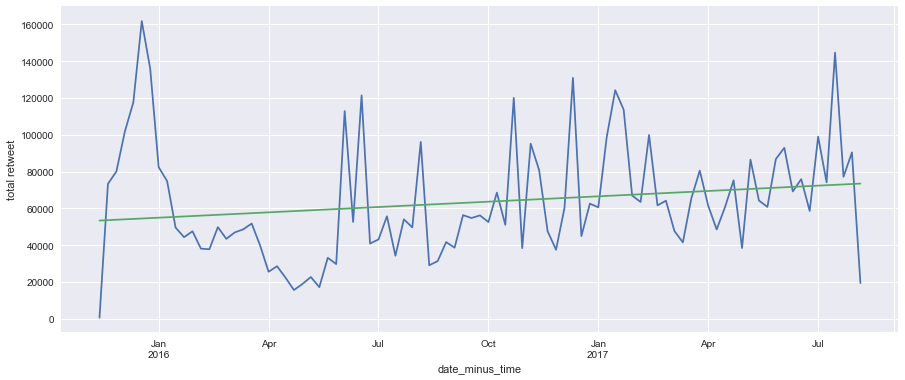

In [67]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)
sns.set()
tweetsum.plot()
regres.plot()
plt.ylabel("total retweet")

# p1 = sns.tsplot(tweetsum,  color="indianred")
# p1.set_xlabel('weeks')

**Average Retweets per week**

In [117]:
tweetAvgs = sdsds['retweet_count'].resample('W', how = 'mean')

c:\python27\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,u'average tweets')

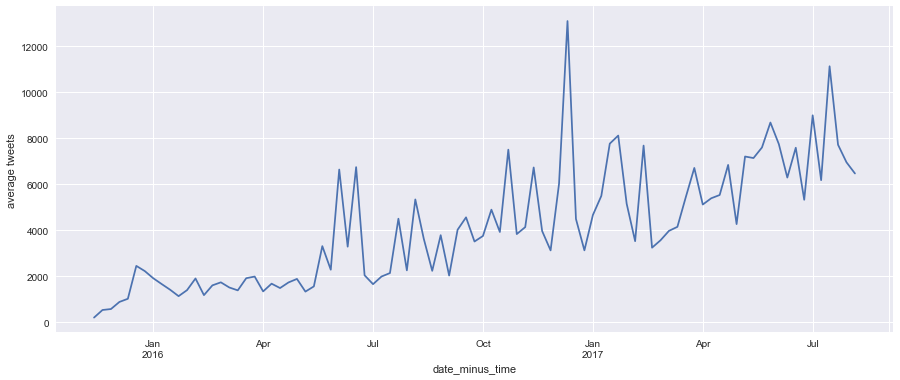

In [141]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)
sns.set()
tweetAvgs.plot()
plt.ylabel("average tweets")
# p1.set_xlabel('weeks')
# p1.set_ylabel('avg retweets')
# sns.tsplot(time = 'date_minus_time', value = 'retweet_count', data = sdsds)

In [147]:
tweetsum.mean()

63417.648351648349

**Findings**<br>
Total retweet counts are averaging at 63,400 per week. But, average tweet counts is on an uptrend growing to about 800 retweets per post. Looking at the trendline for total retweets, the trend is going up

### Most popular dogs by retweet count, what are they?


Typical tweet retweet count

In [132]:
pOnly['retweet_count'].describe()

count     1624.000000
mean      2795.698276
std       4817.343966
min         14.000000
25%        639.000000
50%       1425.500000
75%       3219.250000
max      78479.000000
Name: retweet_count, dtype: float64

In [133]:
mostPopular =pOnly[finishTwits['retweet_count']>=10000]

c:\python27\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,u'breed count')

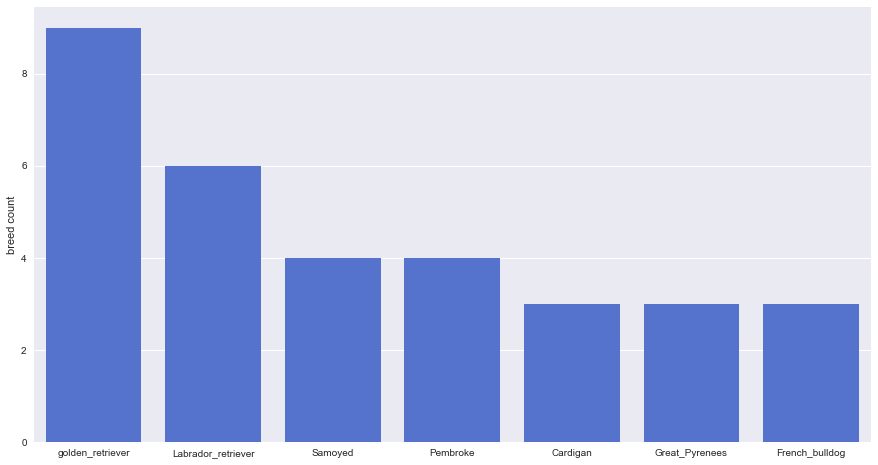

In [134]:
bybreed = mostPopular.p1.value_counts().head(7)
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
ax = sns.barplot(x=bybreed.index, y = bybreed.values, color = 'royalblue')
plt.ylabel("breed count")

Populating the interactive namespace from numpy and matplotlib


c:\python27\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


[None]

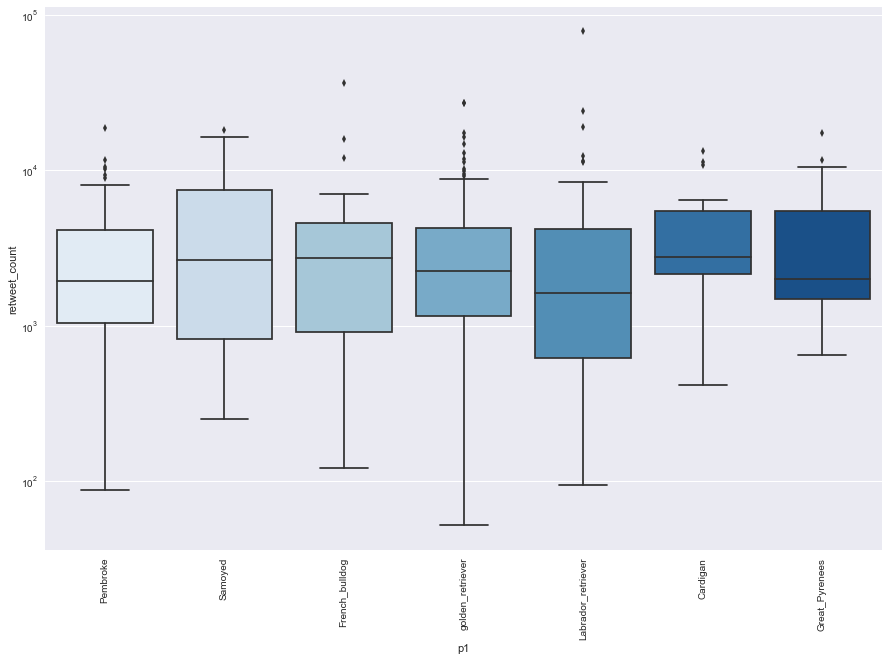

In [135]:
blist =list(bybreed.index)
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
data =pOnly[finishTwits['p1'].isin(blist)]
p =sns.boxplot(x='p1', y='retweet_count', data = data, palette = "Blues")
plt.xticks(rotation=90)
p.set(yscale ="log")

**Findings**<br>
Golden Retrievers and Labrador Retrievers are the most poppular dogs. Other dog breeds that garner the same popularity includes:Permbroke, Semoyed, and French Bulldogs. 
<br>
Looking at the box plot, a labrador retriever once generated ~80,000 retweets! Across the top 7 dogs, the mean tweet counts look constant, but golden and labrador retrievers do pups that are over the 10,000 retweet marks

### Do higher ratings translate to higher retweets?

Populating the interactive namespace from numpy and matplotlib


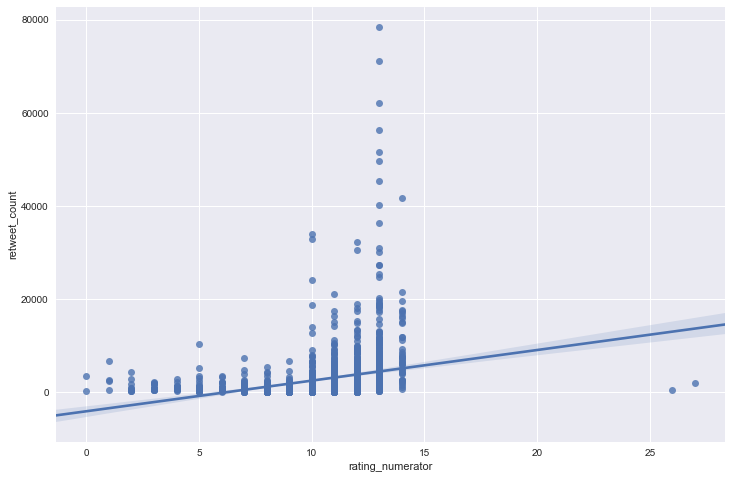

In [202]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
ratingTw = finishTwits[finishTwits['rating_numerator']<30]

p1 =sns.regplot(x= 'rating_numerator', y = 'retweet_count', data = ratingTw, scatter = True)

**Findings**<br>
Does appear higher ratings tend to generate higher retweet counts. But the relationship drops off after a rating of 15. 

### What are people saying on WeRateDogs?


In [179]:
texts=""
for index, row in mostPopular.iterrows():
    rtext= row['text']
    texts = texts + " " + rtext
texts = texts.replace("https", "")
texts = texts.replace("co", "")

Populating the interactive namespace from numpy and matplotlib


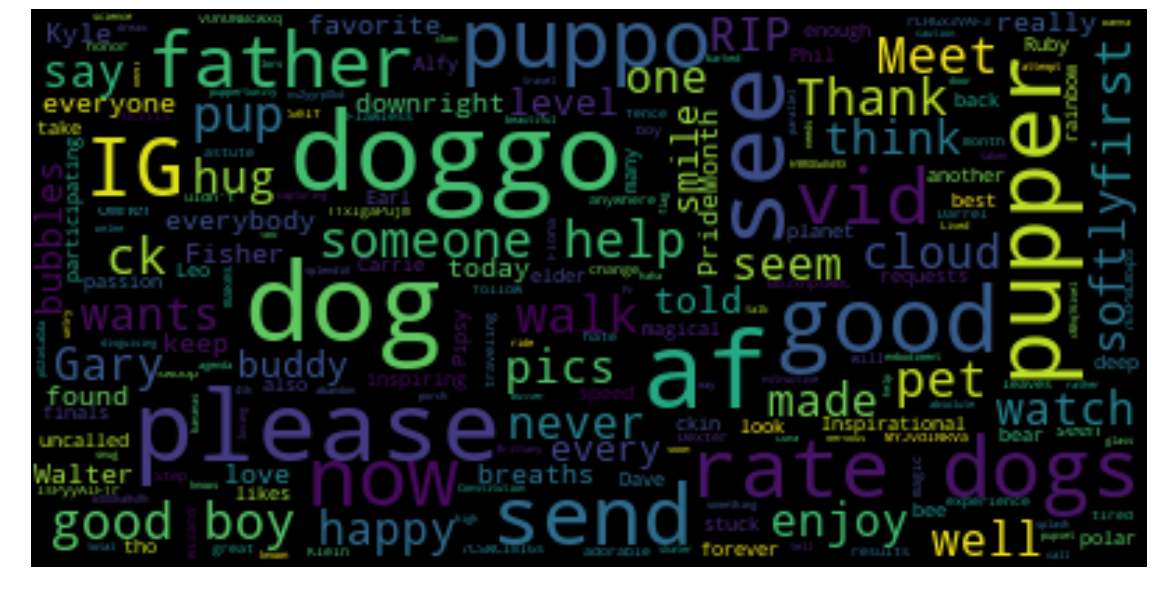

In [182]:
from wordcloud import WordCloud
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)

# wordcloud = WordCloud().generate(texts)
# plt.imshow(wordcloud, interpolation= 'bilinear')
# plt.axis("off")

wordcloud = WordCloud(max_font_size=40).generate(texts)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Findings**<br>
Most of the dogs on WeRateDogs are in the doggo and pupper category. Looks like we have lots of mentions of good boy and father dog on the account. 